In [395]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

index = 254460
seed = index
n_samples = 2560


syn1_x, syn1_t = make_classification(n_samples=n_samples, n_features=2, n_redundant=0, n_repeated=0, n_clusters_per_class=1, random_state=seed)
syn1_train_x, syn1_test_x, syn1_train_t, syn1_test_t = train_test_split(syn1_x, syn1_t, test_size=.2, random_state=seed)
min_max_scaler = preprocessing.MinMaxScaler()
syn1_train_x = min_max_scaler.fit_transform(syn1_train_x)
syn1_test_x = min_max_scaler.transform(syn1_test_x)
syn1_test_x_kl1 = syn1_test_x[syn1_test_t == 1]
syn1_test_x_kl2 = syn1_test_x[syn1_test_t == 0]

syn1_data = {
    'train': {
        'x': syn1_train_x,
        't': syn1_train_t
    },
    'test': {
        'x': syn1_test_x,
        't': syn1_test_t
    }
}

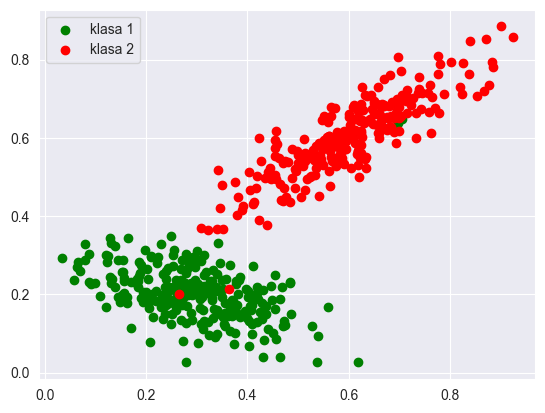

In [396]:
sns.set_style("darkgrid")


plt.scatter(syn1_test_x_kl1[:,0], syn1_test_x_kl1[:,1], c = "g", label="klasa 1")
plt.scatter(syn1_test_x_kl2[:,0], syn1_test_x_kl2[:,1], c = "r", label="klasa 2")
plt.legend()
plt.show()

In [397]:
from sklearn.linear_model import LogisticRegression


clf = LogisticRegression().fit(syn1_data["train"]["x"], syn1_data["train"]["t"])
clf.score(syn1_data["test"]["x"], syn1_data["test"]["t"])

0.984375

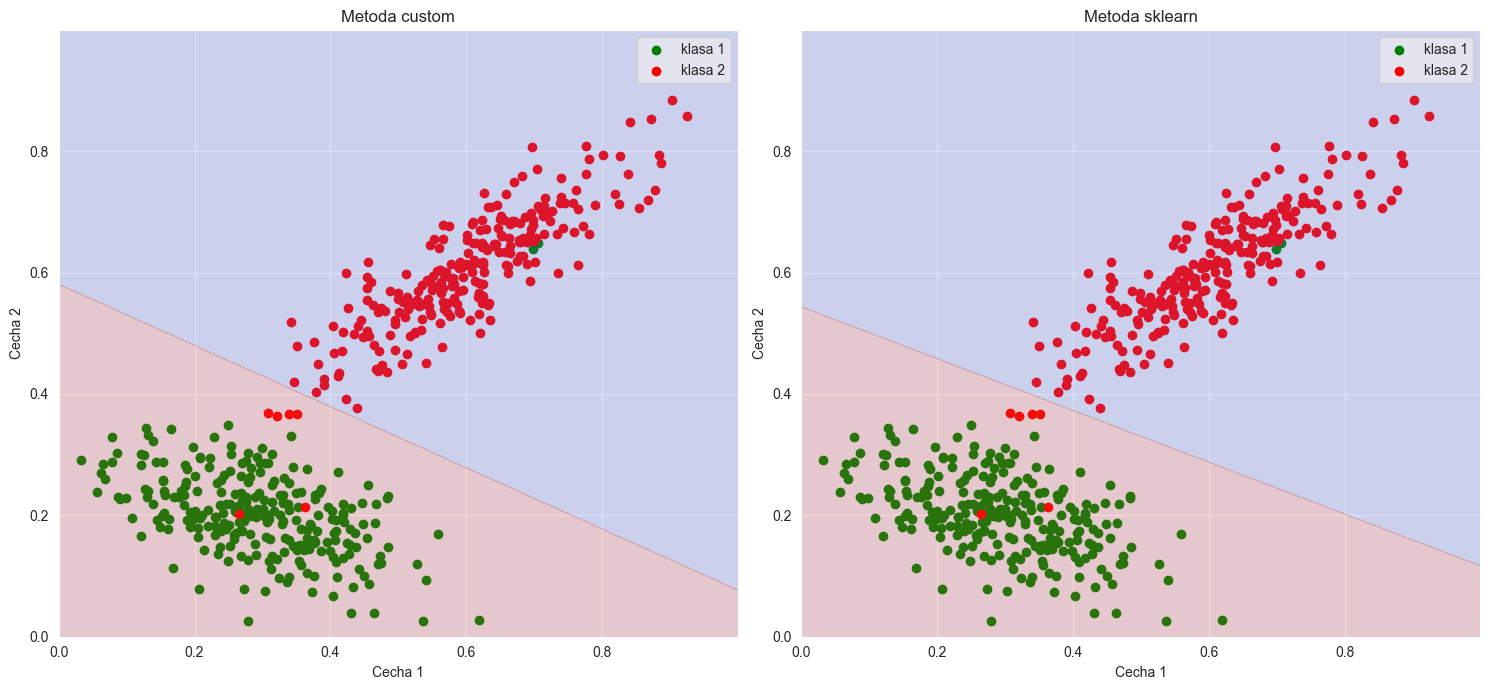

In [398]:
from sklearn.preprocessing import PolynomialFeatures
import statistics


class CustomLogisticRegression:
    def __init__(self, train_data, targets, epoch_nb, threshold) -> None:
        self.BETA = 1
        self.STEP = 0.01
        self.THRESHOLD = threshold
        self.X = train_data
        self.targets = targets
        self.epoch_nb = epoch_nb
        self.teta = np.random.rand(train_data.shape[1],)
        self.cus_prob = np.zeros_like(targets)

    def F(self, S):
        res = np.array(1/(1+np.exp(-self.BETA*S)))
        return res
    
    def fit(self):
        for _ in range(self.epoch_nb):
            for i in range(X.shape[0]):
                self.teta = self.teta + self.STEP*(self.targets[i] - self.F(self.teta.T@self.X[i]))*self.X[i]
            E = [self.targets[i] - self.F(self.teta.T@self.X[i]) for i in range(X.shape[0])]
            if statistics.mean(E) < self.THRESHOLD:
                break
    def predict(self, test_data):
        self.cus_prob = test_data@self.teta
        res = np.array([1 if score >= 0 else 0 for score in self.cus_prob])
        return res


X = syn1_data["train"]["x"]
X = np.hstack([np.ones((X.shape[0], 1)), X])
logistic_regresion = CustomLogisticRegression(X, syn1_data["train"]["t"], 100, 0.01)
logistic_regresion.fit()
xx, yy = np.meshgrid(np.arange(0, 1, 0.001),
                     np.arange(0, 1, 0.001))
poly = PolynomialFeatures(degree=1, include_bias=True)
Z = poly.fit_transform(np.c_[xx.ravel(), yy.ravel()])
Z = logistic_regresion.predict(Z)
Z = Z.reshape(xx.shape)
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
ax = axs[0]
ax.scatter(syn1_test_x_kl1[:,0], syn1_test_x_kl1[:,1], c = "g", label="klasa 1")
ax.scatter(syn1_test_x_kl2[:,0], syn1_test_x_kl2[:,1], c = "r", label="klasa 2")
ax.contourf(xx, yy, Z, alpha=0.2, cmap=plt.cm.coolwarm)
ax.set_title("Metoda custom")
ax.set_xlabel("Cecha 1")
ax.set_ylabel("Cecha 2")
ax.legend()
ax = axs[1]
Z = np.c_[xx.ravel(), yy.ravel()]
Z = clf.predict(Z)
Z = Z.reshape(xx.shape)
ax.scatter(syn1_test_x_kl1[:,0], syn1_test_x_kl1[:,1], c = "g", label="klasa 1")
ax.scatter(syn1_test_x_kl2[:,0], syn1_test_x_kl2[:,1], c = "r", label="klasa 2")
ax.contourf(xx, yy, Z, alpha=0.2, cmap=plt.cm.coolwarm)
ax.set_title("Metoda sklearn")
ax.set_xlabel("Cecha 1")
ax.set_ylabel("Cecha 2")
ax.legend()
fig.tight_layout()

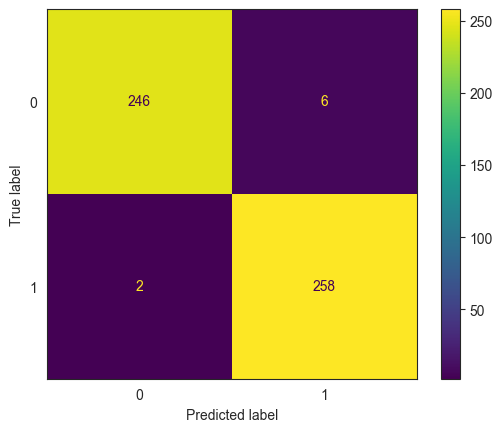

In [399]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


skl_y = clf.predict(syn1_data["test"]["x"])
sns.set_style("white")
cm_S = confusion_matrix(syn1_data["test"]["t"], skl_y)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_S)
disp.plot()
plt.show()

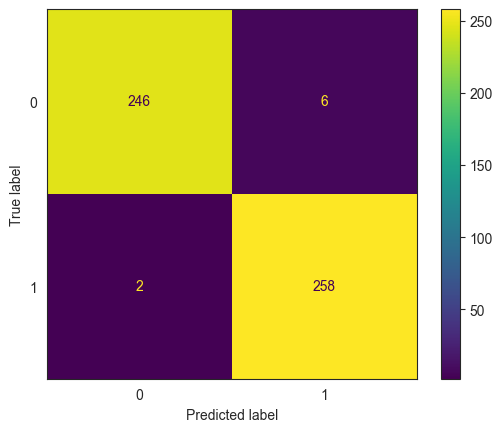

In [400]:
X = syn1_data["test"]["x"]
X = np.hstack([np.ones((X.shape[0], 1)), X])
cus_y = logistic_regresion.predict(X)
cm_S = confusion_matrix(syn1_data["test"]["t"], cus_y)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_S)
disp.plot()
plt.show()

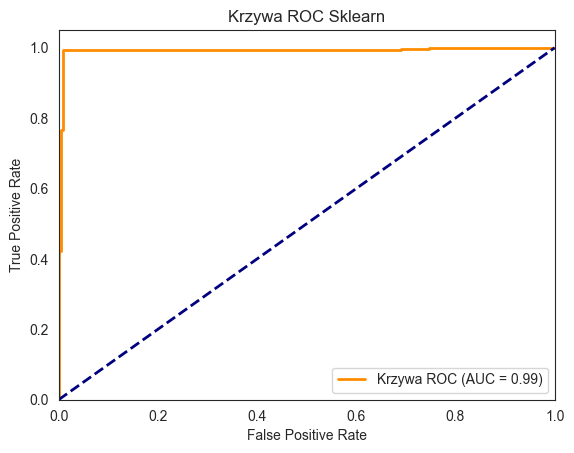

In [401]:
from sklearn.metrics import roc_curve, auc

skl_prob = clf.decision_function(syn1_data["test"]["x"])
fpr, tpr, thresholds = roc_curve(syn1_data["test"]["t"], skl_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Krzywa ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Krzywa ROC Sklearn')
plt.legend(loc="lower right")
plt.show()

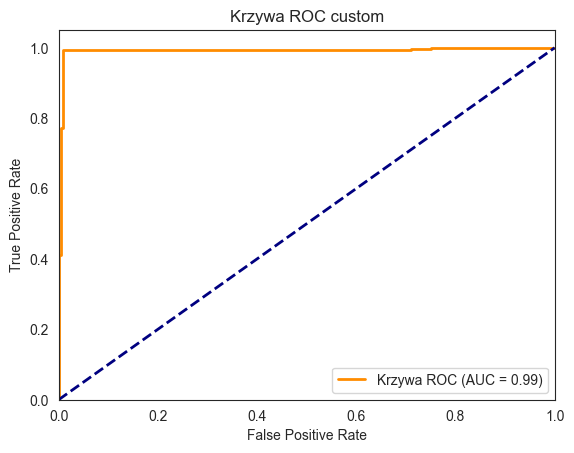

In [402]:
cus_prob = logistic_regresion.cus_prob
fpr, tpr, thresholds = roc_curve(syn1_data["test"]["t"], cus_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Krzywa ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Krzywa ROC custom')
plt.legend(loc="lower right")
plt.show()

In [403]:
from sklearn.datasets import make_moons


syn2_x, syn2_y = make_moons(n_samples=n_samples, random_state=seed, noise=0.1)
syn2_train_x, syn2_test_x, syn2_train_t, syn2_test_t = train_test_split(syn2_x, syn2_y, test_size=.2, random_state=seed)
# syn2_train_x = min_max_scaler.fit_transform(syn2_train_x)
# syn2_test_x = min_max_scaler.transform(syn2_test_x)
syn2_test_x_kl1 = syn2_test_x[syn2_test_t == 0]
syn2_test_x_kl2 = syn2_test_x[syn2_test_t == 1]

syn2_data = {
    "train": 
    {
        "x" : syn2_train_x,
        "t" : syn2_train_t
    },
    "test":
    {
        "x" : syn2_test_x,
        "t" : syn2_test_t
    }
}

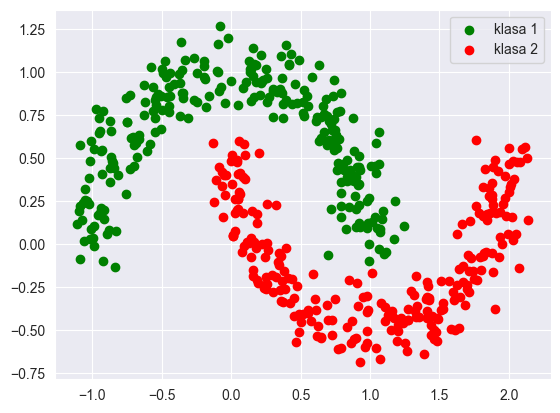

In [404]:
sns.set_style("darkgrid")


plt.scatter(syn2_test_x_kl1[:,0], syn2_test_x_kl1[:,1], c = "g", label="klasa 1")
plt.scatter(syn2_test_x_kl2[:,0], syn2_test_x_kl2[:,1], c = "r", label="klasa 2")
plt.legend()
plt.show()

In [405]:
poly = PolynomialFeatures(degree=3, include_bias=False)
X_train_pol = poly.fit_transform(syn2_data["train"]["x"])
X_test_pol = poly.fit_transform(syn2_data["test"]["x"])
clf = LogisticRegression().fit(X_train_pol, syn2_data["train"]["t"])
clf.score(X_test_pol, syn2_data["test"]["t"])

0.98828125

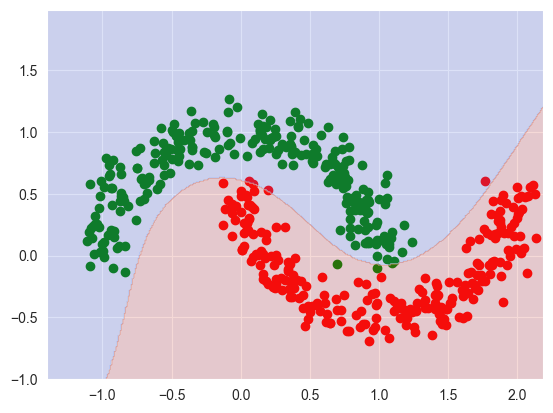

In [406]:
xx, yy = np.meshgrid(np.arange(-1.4, 2.2, 0.01),
                     np.arange(-1, 2, 0.01))
Z = poly.fit_transform(np.c_[xx.ravel(), yy.ravel()])
Z = clf.predict(Z)
Z = Z.reshape(xx.shape)
plt.scatter(syn2_test_x_kl1[:,0], syn2_test_x_kl1[:,1], c = "g", label="klasa 1")
plt.scatter(syn2_test_x_kl2[:,0], syn2_test_x_kl2[:,1], c = "r", label="klasa 2")
plt.contourf(xx, yy, Z, alpha=0.2, cmap=plt.cm.coolwarm)

In [407]:
poly = PolynomialFeatures(degree=3, include_bias=True)
X = syn2_data["train"]["x"]
X_train_pol = poly.fit_transform(X)
logistic_regresion = CustomLogisticRegression(X_train_pol, syn2_data["train"]["t"], 100, 0.001)
logistic_regresion.fit()
X = syn2_data["test"]["x"]
X_test_pol = poly.fit_transform(X)

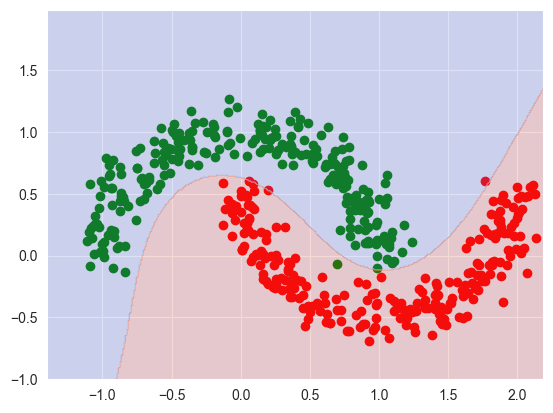

In [408]:
xx, yy = np.meshgrid(np.arange(-1.4, 2.2, 0.01),
                     np.arange(-1, 2, 0.01))
Z = poly.fit_transform(np.c_[xx.ravel(), yy.ravel()])
Z = logistic_regresion.predict(Z)
Z = Z.reshape(xx.shape)
plt.scatter(syn2_test_x_kl1[:,0], syn2_test_x_kl1[:,1], c = "g", label="klasa 1")
plt.scatter(syn2_test_x_kl2[:,0], syn2_test_x_kl2[:,1], c = "r", label="klasa 2")
plt.contourf(xx, yy, Z, alpha=0.2, cmap=plt.cm.coolwarm)

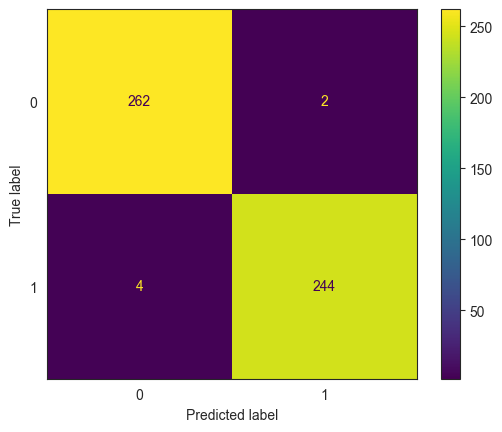

In [409]:
sns.set_style("white")


poly = PolynomialFeatures(degree=3, include_bias=False)
X = syn2_data["test"]["x"]
X_train_pol = poly.fit_transform(X)
skl_y = clf.predict(X_train_pol)
cm_S = confusion_matrix(syn2_data["test"]["t"], skl_y)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_S)
disp.plot()
plt.show()

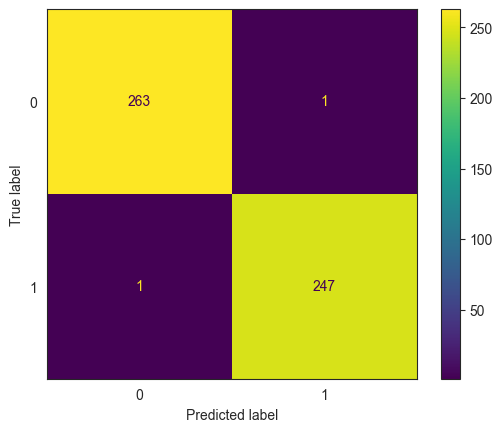

In [410]:
sns.set_style("white")


poly = PolynomialFeatures(degree=3, include_bias=True)
X = syn2_data["test"]["x"]
X_train_pol = poly.fit_transform(X)
cm_y = logistic_regresion.predict(X_train_pol)
cm_S = confusion_matrix(syn2_data["test"]["t"], cm_y)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_S)
disp.plot()
plt.show()

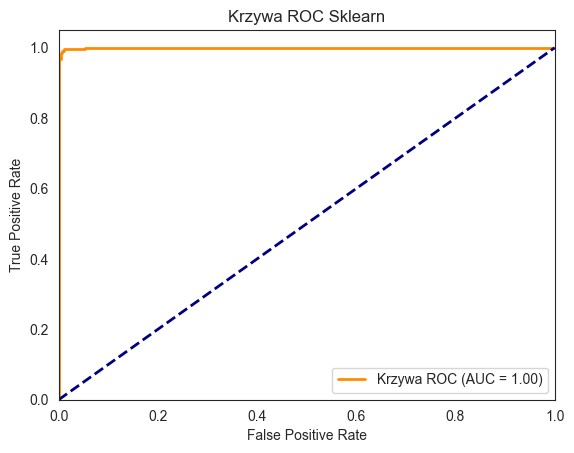

In [411]:
poly = PolynomialFeatures(degree=3, include_bias=False)
X = syn2_data["test"]["x"]
X_train_pol = poly.fit_transform(X)

skl_prob = clf.decision_function(X_train_pol)
fpr, tpr, thresholds = roc_curve(syn2_data["test"]["t"], skl_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Krzywa ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Krzywa ROC Sklearn')
plt.legend(loc="lower right")
plt.show()

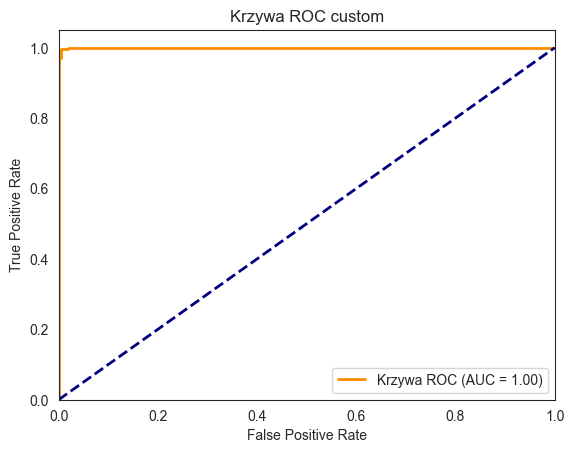

In [412]:
cus_prob = logistic_regresion.cus_prob
fpr, tpr, thresholds = roc_curve(syn2_data["test"]["t"], cus_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Krzywa ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Krzywa ROC custom')
plt.legend(loc="lower right")
plt.show()